In [ ]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector
from scipy import fftpack
from tabulate import tabulate
%matplotlib inline
mpl.rcParams['figure.dpi'] = 160
mpl.rc('text', usetex=True)
plt.rcParams.update({'font.size': 7})
font_size = 7

### Import data
copy the data file from postProcessing/forces/0/coefficient.data to ./data folder

In [ ]:
f_name = "/postProcessing/forces/0/coefficient.dat"
fo_name = "plot_data/cases/"
cases = ['case_100','case_200','case_400']
mesh_size = np.array([100, 200, 400])
data = {}
for case in cases:
    data[case] = np.loadtxt(fo_name+case+f_name, unpack=True, usecols=[0, 1, 3])

In [ ]:
cd_zero_mean = {}
cl_zero_mean = {}
fft_cd = {}
fft_cl = {}

tml = (np.abs(list(data.values())[0][0] - 5.0)).argmin()
markers = ["o","+","s"]
lines = ['-.',"--","-"]
colors = ['#047495',"teal",'#c04e01'] 

diameter = 0.1
labels = [r'$N_x={:d}$'.format(cells) for cells in [100, 200,400]]

fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(8,8))

#ax1 = plt.axes(upper_plot_bounds, xticks=[], xlim=[t_min, t_max], ylim=[0, 10])
ax1.fill_between([4, 8], [3.02, 3.02], [3.24, 3.24], color='k', alpha=0.1) #[-1, 120]
ax1.tick_params(labelsize=font_size)
ax1.set_ylim((2.92,3.25))
ax1.set_ylabel(r"$C_d$", fontsize=font_size)
ax1.set_xlabel(r"$\tilde{t}$", fontsize=font_size)
ax1.axvline(4, ls=":", color="k", alpha=0.25)
ax1.axvline(8, ls=":", color="k", alpha=0.25)

#ax2 = plt.axes(lower_plot_bounds, yticks=[7.0, 7.5, 8.0, 8.5], xlim=[t_min, t_max], ylim=[re_zoom_min, re_zoom_max])
ax2.patch.set_facecolor('k')
ax2.patch.set_alpha(0.1)
ax2.set_ylabel(r"$C_d$", fontsize=font_size)
ax2.set_xlabel(r"$\tilde{t}$", fontsize=font_size)
ax2.tick_params(labelsize=font_size)
ax2.set_xlim((4,8))
ax2.set_ylim((2.92,3.25))
ax2.set_ylim((3.02, 3.24))

# plotting
for i, case in enumerate(cases):
    ax1.plot(data[case][0],data[case][1], lines[i], linewidth=1.2, markevery=70, label=labels[i])
    ax2.plot(data[case][0],data[case][1],lines[i], linewidth=1, markevery=70,  label=labels[i])
ax1.axhline(3.22, ls=":", markevery=0.05, color="k", label="ref.")
ax2.axhline(3.22, ls=":", markevery=0.05, color="k", label="ref.")

# for box and lines
def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, linewidth=1.2, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, linewidth=1.2, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, linewidth=1.2, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2

mark_inset(ax1, ax2, loc1a=1, loc1b=4, loc2a=2, loc2b=3, fc="none", ec="k", alpha=0.2) 

# for legend
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=font_size)

# text in plot
ax2.text(4.5, 3.1, r"enlarged view $ \tilde t ={:.0f}...{:.0f}$".format(4, 8), fontsize=font_size+1, color='k')
ax1.text(4.1, 2.95, r"$ \tilde t =4$", rotation=90, fontsize=font_size, color='k', alpha=0.8)
ax1.text(7.8, 2.95, r"$ \tilde t =8$", rotation=90, fontsize=font_size, color='k', alpha=0.8)
ax2.text(6, 3.222, r"ref. $ C_d =3.22$", fontsize=font_size, color='k')

# Spectrum analysis
for i, case in enumerate(cases):
    cd_zero_mean[case] = data[case][1][tml:] - data[case][1][tml:].mean()
    cl_zero_mean[case] = data[case][2][tml:] - data[case][2][tml:].mean()
    print("mean drag/lift for {:s}: {:2.4f}/{:2.4f}".format(case, np.round(data[case][1][tml:].mean(), 4), np.round(data[case][2][tml:].mean(), 4)))

for i, case in enumerate(cases):
    time_step = (8.0 - 4.0) / data[case][0][tml:].shape[0]
    # drag
    cd_fft = fftpack.fft(cd_zero_mean[case])
    sample_freq = fftpack.fftfreq(cd_fft.size, d=time_step)
    fft_cd[case] = (sample_freq, np.abs(cd_fft))
    # lift
    cl_fft = fftpack.fft(cl_zero_mean[case])
    fft_cl[case] = (sample_freq, np.abs(cl_fft))


fig, (ax) = plt.subplots(1, 1, figsize=(8, 5))
for i, case in enumerate(cases):
    freq, power = fft_cd[case]
    ax.scatter(freq[:100] * diameter, power[:100], s=100, label=labels[i])
    #ax1.plot(freq[:100] * diameter, power[:100], label=labels[i], linewidth=2)
    print("Frequency peak at f={:2.2f}".format(freq[np.argmax(power)]))
ax.set_xlabel("$St$", fontsize=font_size)
ax.set_ylabel("power", fontsize=font_size)
ax.set_xlim(0, 1)
ax.set_ylim(0, 90)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=4, mode="expand", borderaxespad=0., fontsize=font_size)

# sin fit fn
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

# sine curve fitting 
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(8,5))
fig.tight_layout(h_pad=2)

ttt = data['case_200'][0][8000:]
yyy = data['case_200'][1][8000:]
res = fit_sin(ttt, yyy)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, ordinary freq.=%(freq)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

ax1.plot(data['case_200'][0][8000:], data['case_200'][1][8000:], "--k", label="$C_d $", linewidth=1.5)
ax1.plot(data['case_200'][0][8000:], res["fitfunc"](data['case_200'][0][8000:]), "r-", label="$C_d$ sine fit", linewidth=1)
ax1.legend(loc="best")
ax1.set_xlim(4, 8.55)
ax1.set_ylabel(r"$C_d$", fontsize=font_size)
ax1.set_xlabel(r"$\tilde{t}$", fontsize=font_size)

ttt = data['case_400'][0][8000:]
yyy = data['case_400'][1][8000:]
res = fit_sin(ttt, yyy)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, ordinary freq.=%(freq)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

ax2.plot(data['case_400'][0][8000:], data['case_400'][1][8000:], "--k", label="$C_d $", linewidth=1.5)
ax2.plot(data['case_400'][0][8000:], res["fitfunc"](data['case_400'][0][8000:]), "r-", label="$C_d$ sine fit", linewidth=1)
ax2.legend(loc="best")
ax2.set_xlim(4, 8.55)
ax2.set_ylabel(r"$C_d$", fontsize=font_size)
ax2.set_xlabel(r"$\tilde{t}$", fontsize=font_size)

# text in plot
ax1.text(8.1, 3.17, r"$N_x =200$", fontsize=font_size+2, color='k')
ax2.text(8.1, 3.17, r"$N_x =400$", fontsize=font_size+2, color='k')

#### Ploting values of Cd and Cl after 3s 
File will be saved in /plots dir

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(8,8))

#ax1 = plt.axes(upper_plot_bounds, xticks=[], xlim=[t_min, t_max], ylim=[0, 10])
ax1.fill_between([4, 8], [-1.5, -1.5], [1.5, 1.5], color='k', alpha=0.1) #[-1, 120]
ax1.tick_params(labelsize=font_size)
ax1.set_ylabel(r"$C_l$")
ax1.set_xlabel(r"$\tilde{t}$", labelpad=15)
ax1.axvline(4, ls=":", color="k", alpha=0.25)
ax1.axvline(8, ls=":", color="k", alpha=0.25)

#ax2 = plt.axes(lower_plot_bounds, yticks=[7.0, 7.5, 8.0, 8.5], xlim=[t_min, t_max], ylim=[re_zoom_min, re_zoom_max])
ax2.patch.set_facecolor('k')
ax2.patch.set_alpha(0.1)
ax2.set_ylabel(r"$C_l$")
ax2.set_xlabel(r"$\tilde{t}$", fontsize=font_size)
ax2.tick_params(labelsize=font_size)
ax2.set_xlim((4,8))
ax2.set_ylim((-1.5,1.5))
ax1.axhline(0.99, ls=":", color="k", label="ref.")
ax2.axhline(0.99, ls=":", color="k", label="ref.")

# plotting
for i, case in enumerate(cases):
    ax1.plot(data[case][0],data[case][2], ls=lines[i], linewidth=1.2, markevery=70, label=labels[i])
    ax2.plot(data[case][0],data[case][2], ls=lines[i], linewidth=1.2, markevery=70, label=labels[i])
ax2.axhline(0.99, ls=":", color="k", label="ref.")

#for box and lines
mark_inset(ax1, ax2, loc1a=1, loc1b=4, loc2a=2, loc2b=3, fc="none", ec="k", alpha=0.2) 

# for legend
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=4, mode="expand", borderaxespad=0., fontsize=font_size)

# text in plot
ax2.text(4.5, -1.25, r"enlarged view $ \tilde t ={:.0f}...{:.0f}$".format(4, 8), fontsize=font_size+1, color='k')
ax1.text(4.1, -1.35, r"$ \tilde t =4$", rotation=90, fontsize=font_size, color='k', alpha=0.8)
ax1.text(7.8, -1.35, r"$ \tilde t =8$", rotation=90, fontsize=font_size, color='k', alpha=0.8)
ax2.text(6, 1.03, r"ref. $ C_l =0.99$", fontsize=font_size, color='k')

#spectrum analysis
fig, ax = plt.subplots(1, 1, figsize=(8,5))
for i, case in enumerate(cases):
    freq, power = fft_cl[case]
    ax.scatter(freq[:100] * diameter, power[:100], s=100, label=labels[i])
    print("Frequency peak at f={:2.2f}".format(freq[np.argmax(power)]))
ax.axvline(0.295, ls=":", color="k", label="ref.")

ax.set_xlabel("$St$", fontsize=font_size)
ax.set_ylabel("power", fontsize=font_size)
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 3500)
ax.tick_params(labelsize=font_size)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=font_size)

# sine curve fitting 
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(8,5))
fig.tight_layout(h_pad=2)

ttt = data['case_200'][0][8000:]
yyy = data['case_200'][2][8000:]
res = fit_sin(ttt, yyy)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, ordinary freq.=%(freq)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

ax1.plot(data['case_200'][0][8000:], data['case_200'][2][8000:], "--k", label="$C_l $", linewidth=1.5)
ax1.plot(data['case_200'][0][8000:], res["fitfunc"](data['case_200'][0][8000:]), "r-", label="$C_l$ sine fit", linewidth=1)
ax1.legend(loc="best")
ax1.set_xlim(4, 8.55)
ax1.set_ylabel(r"$C_l$", fontsize=font_size)
ax1.set_xlabel(r"$\tilde{t}$", fontsize=font_size)

ttt = data['case_400'][0][8000:]
yyy = data['case_400'][2][8000:]
res = fit_sin(ttt, yyy)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, ordinary freq.=%(freq)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

ax2.plot(data['case_400'][0][8000:], data['case_400'][2][8000:], "--k", label="$C_l $", linewidth=1.5)
ax2.plot(data['case_400'][0][8000:], res["fitfunc"](data['case_400'][0][8000:]), "r-", label="$C_l$ sine fit", linewidth=1)
ax2.legend(loc="best")
ax2.set_xlim(4, 8.55)
ax2.set_ylabel(r"$C_l$", fontsize=font_size)
ax2.set_xlabel(r"$\tilde{t}$", fontsize=font_size)

# text in plot
ax1.text(8.1, 0, r"$N_x =200$", fontsize=font_size+2, color='k')
ax2.text(8.1, 0, r"$N_x =400$", fontsize=font_size+2, color='k')

  Case no.  Case        Cell size(x)    min value after 5s(Cd)    mean value after 5s(Cd)    max value after 5s(Cd)
----------  --------  --------------  ------------------------  -------------------------  ------------------------
         1  case_100             100                   3.05413                    3.06098                   3.06604
         2  case_200             200                   3.14741                    3.17212                   3.19653
         3  case_400             400                   3.14756                    3.17533                   3.20258


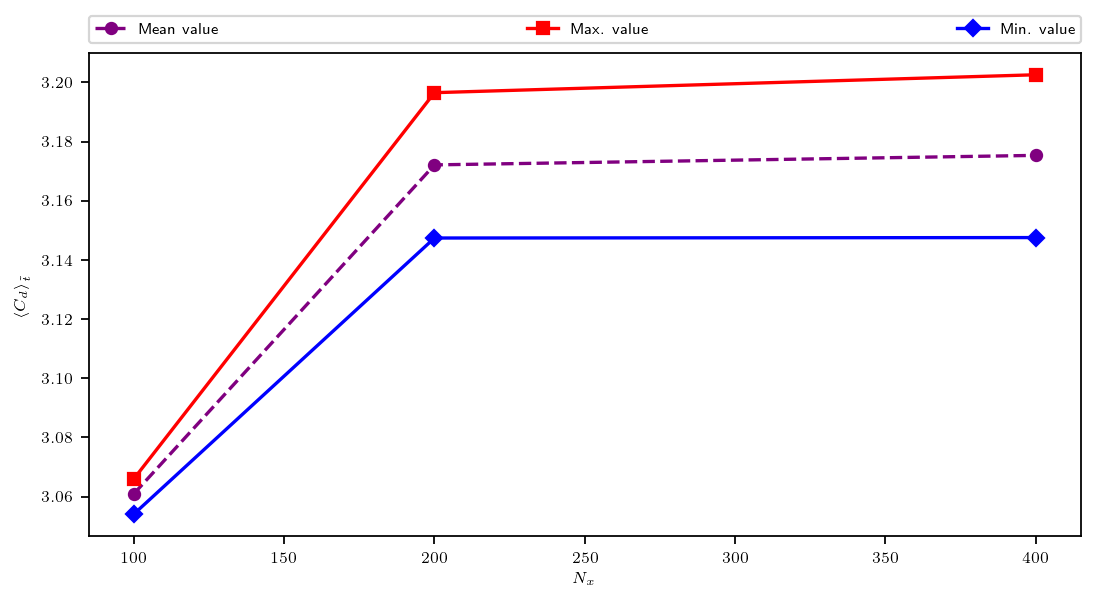

In [16]:
colors = ["red","blue","green"]
mean_cd = np.zeros(mesh_size.shape)
max_cd = np.zeros(mesh_size.shape)
min_cd = np.zeros(mesh_size.shape)
fig, ax = plt.subplots(1,1,figsize=(8,4))

for i, case in enumerate(cases):
    mean_cd[i] = data[case][1][tml:].mean()
    max_cd[i]  = data[case][1][tml:].max()
    min_cd[i]  = data[case][1][tml:].min()
ax.plot(mesh_size, mean_cd, '--o', markersize=5, color='Purple', label="Mean value")
ax.plot(mesh_size, max_cd, '-s', markersize=5, color='r', label="Max. value")
ax.plot(mesh_size, min_cd, '-D', markersize=5, color='b', label="Min. value")
ax.set_xlabel(r"$N_x$", fontsize=font_size)
ax.set_ylabel(r"${\langle C_d \rangle}_{\tilde{t}}$", fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=font_size)

#print mean values
p_data = [[0]*6]*len(mesh_size)
for i, case in enumerate(cases):
    p_data[i] = [i+1, case, mesh_size[i], min_cd[i], mean_cd[i], max_cd[i]]
print (tabulate(p_data, headers=["Case no.", "Case", "Cell size(x)", "min value after 5s(Cd)", "mean value after 5s(Cd)" , "max value after 5s(Cd)"]))

  Case no.  Case        Cell size(x)    min value after 5s(Cl)    mean value after 5s(Cl)    max value after 5s(Cl)
----------  --------  --------------  ------------------------  -------------------------  ------------------------
         1  case_100             100                 -0.546845                 -0.0906619                  0.343828
         2  case_200             200                 -0.904919                 -0.0126599                  0.878955
         3  case_400             400                 -0.953915                 -0.0164522                  0.918634


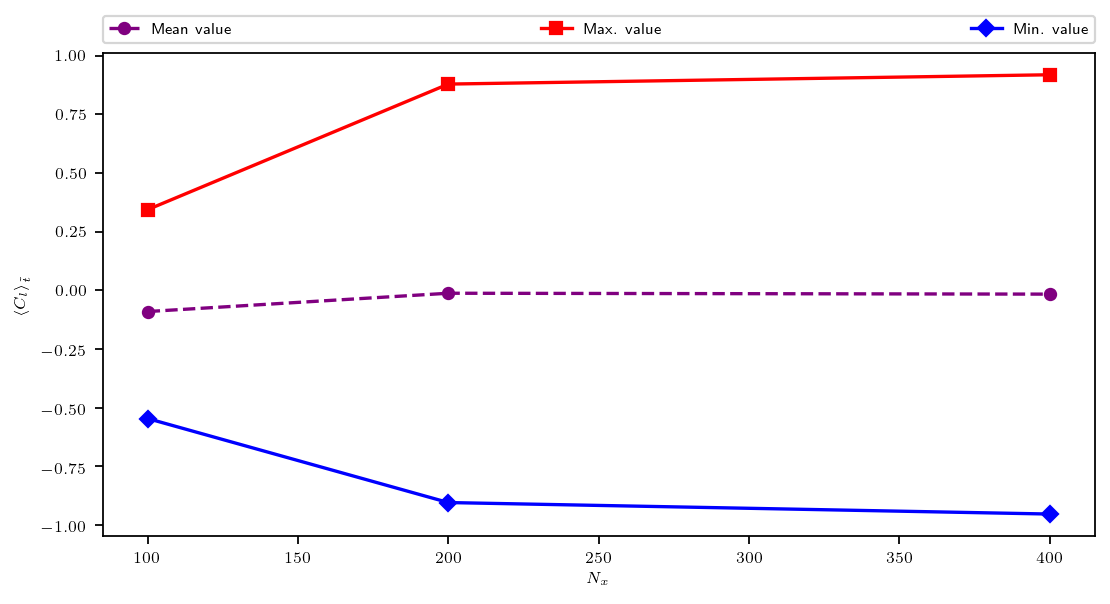

In [17]:
mean_cl = np.zeros(mesh_size.shape)
max_cl = np.zeros(mesh_size.shape)
min_cl = np.zeros(mesh_size.shape)
plot, ax = plt.subplots(1,1,figsize=(8,4))

for i, case in enumerate(cases):
    mean_cl[i] = data[case][2][tml:].mean()
    max_cl[i]  = data[case][2][tml:].max()
    min_cl[i]  = data[case][2][tml:].min()
ax.plot(mesh_size, mean_cl, '--o', color='purple', markersize=5, label="Mean value")
ax.plot(mesh_size, max_cl, '-s', color='r', markersize=5, label="Max. value")
ax.plot(mesh_size, min_cl, '-D', color='b', markersize=5, label="Min. value")
ax.set_xlabel(r"$N_x$", fontsize=font_size)
ax.set_ylabel(r"${\langle C_l \rangle}_{\tilde{t}}$", fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=font_size)

#print mean/min/max values
header = ["Case no.", "Case", "Cell size(x)", "min value after 5s(Cl)", "mean value after 5s(Cl)", "max value after 5s(Cl)"]
p_data = [[0]*len(header)]*len(mesh_size)

for i, case in enumerate(cases):
    p_data[i] = [i+1, case, mesh_size[i], min_cl[i], mean_cl[i], max_cl[i]]
print (tabulate(p_data, headers=header))